# Predict size of cluster from text content

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils import shuffle

%matplotlib inline

import lib.helper as helper

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score              # Evaluate a model
from sklearn.metrics import f1_score                    # Evaluate a model
from sklearn.metrics import precision_score             # Evaluate a model
from sklearn.metrics import recall_score                # Evaluate a model

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Tools for evaluating the model by running it repeatedly with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

## 01.  Create features, labels, train-val-test split

In [29]:
# Load the corpus
df = pd.read_csv("working/RSS_clustered_louvain.csv")

In [30]:
# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(helper.preprocess_description)
df['phrased_tokens'] = helper.get_phrased_nouns(df['clean_text'])

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

df = df[df['cluster'] != -1]
#df['cluster_size'] = np.where(df['cluster']==-1, 0.0, df['cluster_size'])

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']]

,cluster_size,tokens,phrased_tokens
4,863,"[syria, war, turkey, warn, europ, new, migrant...","[syria_turkey, europ, presid_erdogan, syria]"
29,82,"[trump, news, presid, lash, amid, widespread, ...","[presid, afghan, donald_trump, oval_offic, hur..."
33,59,"[berni, sander, take, victori, lap, iowa, stat...","[berni_sander, iowa, state, fair, soapbox, iow..."
34,6,"[itali, success, eject, far, right, leader, sa...","[itali_salvini, matteo_salvini, leagu, europ]"
44,82,"[trump, launch, angri, attack, grace, star, hu...","[grace, hurrican_dorian, ms, mess, american, m..."
...,...,...,...
31379,20,"[trump, coward, complicit, russia, bounti, cla...","[russia, ex, navi_seal, donald_trump]"
31383,505,"[insid, amsterdam, red, light, district, sex, ...","[amsterdam, pm, mark, rutt, amsterdam, red, li..."
31385,291,"[kim, jong, threaten, ww, south, korea, dirti,...","[kim_jong, ww, south_korea, north_korea, kim_j..."
31391,584,"[far, bank, england, predict, quick, econom, b...","[bank_england, quick, econom, uk, gdp]"


In [31]:
vectorizer = TfidfVectorizer(decode_error="ignore",
                             max_features=5000)

# Create feature vectors
X = vectorizer.fit_transform(df['tokens'].apply(" ".join))

# Create Labels
y = np.asarray(df['cluster_size'].astype(float))

# Check that worked
print(X.shape, y.shape)

# Split the data, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(6131, 5000) (6131,)


In [32]:
# Define the measurements we want to make
scoring = {'MSE': make_scorer(mean_squared_error),
           'MAE': make_scorer(mean_absolute_error)}

#algo = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1)
algo = LinearRegression()

results = cross_validate(algo,
                         X_train,
                         y_train,
                         cv=10,
                         return_train_score=True,
                         return_estimator=True,
                         n_jobs=-1)

y_pred = cross_val_predict(algo, X_train, y_train, cv=10)

In [33]:
{key: np.mean(value) for key, value in results.items() if key != 'estimator'}

{'fit_time': 2.1186694860458375,
 'score_time': 0.001561117172241211,
 'test_score': -0.9240338048104075,
 'train_score': 0.9999999999764965}

## Diagnostic training plots here

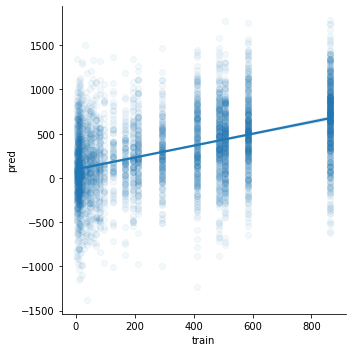

In [34]:
temp_df = pd.DataFrame({"train": y_train,
                        "pred": y_pred})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

## Examine features using simple linear regression